# 非線形なモデルとPreprocessing
## 前回行ったこと
 - 交差検証
 - グリッドサーチによるハイパーパラメータチューニング

## 今回行うこと
- 非線形なモデルを動かす
- 特徴ベクトルに対する学習前の処理

## （復習）データの読み込み・特徴ベクトルの構築
one-hotエンコーディングを用いた特徴ベクトルを再び作ります．
もう詳しく説明することはしません．
全て一つのセルにまとめました．
詳細は前回の資料を参照してください．

In [1]:
import numpy as np
import pandas as pd

# Google Colabを用いる場合、以下のコメントアウトを外して実行
from google.colab import drive
drive.mount('/content/drive') # google driveをマウント（＝Colabから使えるようにする）
d_train = pd.read_csv("drive/My Drive/data/train.csv") # 訓練データを読み込む．パスは適宜変更すること
d_test = pd.read_csv("drive/My Drive/data/test.csv") # テストデータを読み込む．パスは適宜変更すること

# ローカル環境を用いる場合、以下のコメントアウトを外して実行
# d_train = pd.read_csv("/data/train.csv") # 訓練データを読み込む．パスは適宜変更すること
# d_test = pd.read_csv("/data/test.csv") # テストデータを読み込む．パスは適宜変更すること

print("訓練データとテストデータの数を取得")
n_train = len(d_train)
n_test = len(d_test)
print(f"訓練データ数：{n_train}，テストデータ数：{n_test}")

# targetの値
y_train = d_train.pop('popularity')
y_train = y_train.to_numpy() # numpyのarrayに変換
print(y_train)

# one-hot encoding
d_all = pd.concat([d_train, d_test], axis=0) # 訓練データとテストデータを連結
d_all = d_all.astype({'explicit': int}) # `explicit`の列の型をintにキャスト
columns_cat = ["track_genre"] # カテゴリカル変数の列名

d_all_onehot = pd.get_dummies(d_all, columns=columns_cat, dtype=int) # get_dummiesを使ってone-hotエンコーディング．columnsに指定された列のみone-hotエンコーディングし，出力としてint型を指定
d_train_onehot = d_all_onehot[:n_train] # d_all_onehotの訓練データ部分
d_test_onehot = d_all_onehot[n_train:] # d_all_onehotのテストデータ部分
X_train = d_train_onehot.select_dtypes(include=['int64', 'float64']).to_numpy() # 数値部分のみ取り出し，np.arrayに変換
X_test = d_test_onehot.select_dtypes(include=['int64', 'float64']).to_numpy()  # 数値部分のみ取り出し，np.arrayに変換

Mounted at /content/drive
訓練データとテストデータの数を取得
訓練データ数：79800，テストデータ数：34200
[43  0 50 ... 60 44 24]


いい加減しつこい気もしますが，復習と予測結果の比較のために`LinearRegression`を動かしておきます．
ハイパーパラメータ（学習するのではなく，ユーザが決める要素）はここでは`fit_intercept=False`，`normalize=False`とします．

In [22]:
from sklearn.linear_model import LinearRegression # LinearRegressionを使えるようにする
lr = LinearRegression(fit_intercept=False) # インスタンスの作成
lr.fit(X_train, y_train)
y_pred_test_lr = lr.predict(X_test)
print(y_pred_test_lr)

[36.07987563 32.40019485 55.05526121 ... 45.410423   42.58279019
 40.51070228]


## 非線形なモデルを動かす
これまでは線形回帰とリッジ回帰を動かしてきました．
これらはどちらもモデルとしては同じで，以下の式で表される線形モデルです：
$$y(\mathbf{x};\mathbf{w}) = \mathbf{w}^\top \mathbf{x},$$
ここで $\mathbf{w} \in \mathbb{R}^d$ は学習する重みです（簡単のため，バイアス項（bias term）（あるいは切片（intercept））は無視します．

線形モデルは予測モデルの中でも最も単純でわかりやすいものの一つです．
しかし，現実の多くの問題はこの単純なモデルで説明することができないことが多いです．
例えば，**全ての特徴の値が2倍になった時，線形モデルの予測の値も2倍**になりますが，この性質がどのような問題でも望ましいとは限りません．

また，各特徴の要素に対して別々の重みを掛けてその結果を足しているだけで，**特徴同士の相互作用**のようなものを一切考えていません．
楽曲の例ですと，例えば，「ジャンルはジャンル」「テンポ(BPM)はテンポ」で独立に考えています．
したがって，線形モデルにおいて，楽曲のジャンルが何であろうともテンポごとの傾向・バイアスは変わらず，同様にどのテンポであろうともジャンルごとの傾向・バイアスは変わりません．
しかし，一般に楽曲のジャンルによってテンポの傾向は変わる可能性がありそうです．アップテンポな楽曲の多いジャンルがある一方で，落ち着いた曲調の楽曲が多いジャンルもあるかもしれません．
しかし，線形モデルではそのようなことを考慮することができません．

そこで今回は**非線形なモデル**を使ってみることにします．
今回はsklearnによって提供されている非線形なモデルの中から適当に選んで使ってみます．
勿論，モデルの持つ非線形性が実際のデータとかけ離れていれば，（妥当なモデルと比べて）上手くいきません．
また，非線形なモデルは表現能力（フィッティング能力）が高いことが多く，データが少ない場合は過学習を起こしてしまう可能性もあります．
そのことに注意しながら使ってみましょう．

### 多層パーセプトロン（Multi-layer perceptron，MLP）を動かす
sklearnには多数の非線形なモデルが実装されています．
今回はその中でも，[多層パーセプトロン（Multi-layer perceptron, MLP）](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)を動かしてみます．
**MLPはニューラルネットワーク**の一種で，多層のニューラルネットワークの中では最もベーシックなものです．
MLPは，数理的には，
1. ベクトルに行列を掛ける
2. 活性化関数と呼ばれる非線形な関数を噛ませる

を繰り返したモデルです．
MLPをノード（点）とエッジ（線）を用いてグラフィカルに表現すると，上の2つの演算を繰り返した回数だけ，入力と出力の間に「層」があるように見えます．
そのため，上の2つの演算を行う回数を中間層（隠れ層）の数と言い，掛ける行列のことを中間層の重み（行列）と呼びます．
中間層の重み行列がMLPの学習するパラメータで，**勾配法**と呼ばれる方法で学習を行います．
勾配法（とくに，ここでは誤差関数の最小化を考えることにするので，勾配降下法）は，簡単に説明すると以下のような反復を行うアルゴリズムです：

1. パラメータ $\mathbf{\Theta}$ の初期値 $\mathbf{\Theta}^{(0)}$を定め，以下の2と3を収束するまで繰り返す．
2. 最小化したい関数 $L$ に対するパラメータの勾配 $\nabla L(\mathbf{\Theta})$ を計算する．ニューラルネットワークにおいては，この勾配の計算を**誤差逆伝播法（Backpropagation）**と呼ばれる方法で効率よく行う．
3. 2で求めた勾配を使ってパラメータを少し動かす．例えば勾配降下法の一種である最急降下法では以下のように動かす：

    $$\mathbf{\Theta}^{(n)} \leftarrow \mathbf{\Theta}^{(n-1)} - \eta \nabla L(\mathbf{\Theta}^{(n-1)})$$

ここで， $\eta > 0$ は学習率やステップサイズと呼ばれるハイパーパラメータで，一回の反復でどの程度パラメータを動かすかを表す．

一応簡単に説明しましたが，これでは不十分・わかりにくいように思います．
詳細は，例えば[scikit-learnの解説](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised)や，[授業で使っている教科書](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)や，その他多数の書籍やWeb上の記事を参考にしてみてください（「人工知能」の授業で触れているのではないかとも思いますが）．

では実際に使ってみます．
まずはimportですが，回帰のためのMLPは`MLPRegressor`という名前で，`sklearn.neural_network`の中にあります．

In [23]:
from sklearn.neural_network import MLPRegressor

それではとりあえず，デフォルトのパラメータで使ってみましょう．
デフォルト設定のモデルの評価（NOTチューニング）をするために，`cross_validate`をimportします．
また，後のため，`GridSearchCV`もimportします．

In [24]:
from sklearn.model_selection import cross_validate, GridSearchCV

前回と同様に，`cross_validate`で評価をしてみます．
`cross_validate`には，学習・評価をしたいモデルとデータ，そして分割数とスコア関数（の名前）を与えるのでした．
前回同様，分割数`cv=5`とし，スコア関数は`"neg_mean_squared_error"`とします．
`cross_validate`を動かすと`scores`という辞書オブジェクトが返ってきます．
`"test_score"`というキーで交差検証のスコアを取得できるのでした．
5回のスコアとその平気を最後にprintします．
結局，以下のようになります（前回のほぼコピペ）．

In [25]:
mlp = MLPRegressor(random_state=42) # random_state(乱数のseed値)を指定して初期パラメータを固定(比較検証用)
scores = cross_validate(mlp, X_train, y_train, cv=5,
                        scoring="neg_mean_squared_error")
print(f"交差検証の5回のスコア：{-scores['test_score']}")
print(f"交差検証の平均スコア：{-np.mean(scores['test_score'])}")

交差検証の5回のスコア：[29226.71228611   511.07319888  5097.66109713   899.22325887
  7827.98131716]
交差検証の平均スコア：8712.530231631392


少し待った時間がかかった結果，(私の環境では)**微妙なスコア**が返ってきました．

ひどい過学習をしているのかなと思いつつ，一応，**訓練データに対するスコア**を確認してみます．
「訓練データに対するスコアを参考にするな」と以前の資料では言ったように思いますが，訓練データに対するスコアは以下のように使うことができます：**訓練データに対するスコアも悪い場合，そもそも学習ができていない**ので，**プログラムの使い方を大きく間違っている**・**そもそもプログラムにバグがある**（今回は考えにくいですが，自身でコアのアルゴリズムを実装した場合はあり得ます）と言ったことを検出できます（つまり，**過学習以前の問題**が起こっている）．
この場合，ドキュメントを注意深く読み直す必要があります．

`cross_validate`では，`return_train_score`という引数を`True`にすることで，訓練時のスコアも取得できます．
`train_score`というキーでアクセスできます（`cross_validate`は辞書型オブジェクトを返すのでしたね）．
ちょっと面倒ですが，もう一度交差検証をしてみます．

In [26]:
mlp = MLPRegressor(random_state=42) # random_state(乱数のseed値)を指定して初期パラメータを固定(比較検証用)
scores = cross_validate(mlp, X_train, y_train, cv=5,
                        scoring="neg_mean_squared_error",
                        return_train_score=True)
print(f"交差検証の5回のスコア：{-scores['test_score']}")
print(f"交差検証の平均スコア：{-np.mean(scores['test_score'])}")

print(f"交差検証の5回の訓練スコア：{-scores['train_score']}")
print(f"交差検証の平均訓練スコア：{-np.mean(scores['train_score'])}")

交差検証の5回のスコア：[29226.71228611   511.07319888  5097.66109713   899.22325887
  7827.98131716]
交差検証の平均スコア：8712.530231631392
交差検証の5回の訓練スコア：[29169.70763141   511.34666255  5273.61308857   906.37580392
  7690.96864554]
交差検証の平均訓練スコア：8710.40236639496


……ということで[ドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)を読みに行きましょう．
ハイパーパラメータの数に圧倒されるかもしれませんが，どうか諦めないでください．
いくつかのパラメータに関して簡単に見ていきます．
- `hidden_layer_sizes`：intのタプル（リストのようなもの），隠れ層（中間層）のユニット数．例えば，`(100, 50, 20)`を指定すると，中間層の数が3つで，入力に近い方から順に中間層のユニット数が100, 50, 20となる．中間層の数は「行列を掛ける」「活性化関数を噛ませる」回数に対応し，ユニット数は行列を掛けた後のベクトルの要素数に対応します．つまり，ネットワークの構造（深さと広さ）を定めるものです．
- `activation`：string，活性化関数（行列を掛けた後に作用させる非線形な関数）．ここでは，
  - `"identity"`：恒等関数 $g(x)=x$
  - `"logistic"`：ロジスティックシグモイド関数 $g(x)=1 / (1+e^{-x})$
  - `"tanh"`：ハイパボリックタンジェント $g(x)=(e^{x}-e^{-x}) / (e^{x}+e^{-x})$
  - `"relu"`：ReLU(**Re**ctified **L**inear **U**nit)関数 $g(x)= \max (0, x)$
  
  の4つを選択できる．デフォルトは`"relu"`．
- `solver`：string，最適化手法．MLPは勾配法で最適化すると言いましたが，一口に勾配法と言っても実は色々あり，ここでは，
  - `"lbfgs"`：準ニュートン法（quasi-newton method）と呼ばれる方法の一種．ヘッセ行列（＝二回微分）を近似し，上手く用いる．
  - `"sgd"`：確率的勾配降下法（stochastic gradient descent, SGD），一回の反復に全てのデータではなく一部のデータのみを用いる．
  - `"adam"`：SGDの一種で，勾配の使い方・ステップサイズに色々と工夫が施されている．
  
  の3つを指定できる．デフォルトは`"adam"`．
- `alpha`：float，正則化項の強さ（Ridge回帰と同じ）．
- `batch_size`：int， SGD・Adamにおいて，一回の反復で用いるデータの数．
- `learning_rate_init`：float，初期学習率．デフォルトは`0.001`．
- `max_iter`：int，最大反復回数．デフォルトは200.
- `beta_1`, `beta_2`：float，`"Adam"`のハイパーパラメータ．

ちょっと疲れたのでこの辺にしておきます．
まず，最初の`hidden_layer_sizes`と`activation`は，ネットワークの構造を決めるものなので性能に直結しそうですね．
また，最適化アルゴリズムの選択および最適化アルゴリズムのハイパーパラメータの選択も非常に重要です．
ここではとりあえず，他のハイパーパラメータはそのままで，先程試した`"relu"`以外の活性化関数を用いて交差検証で評価してみましょう

In [27]:
for activation in ["identity", "logistic", "tanh"]:
    print(f"活性化関数：{activation}")
    mlp = MLPRegressor(activation=activation, random_state=42) # random_state(乱数のseed値)を指定して初期パラメータを固定(比較検証用)
    scores = cross_validate(mlp, X_train, y_train, cv=5,
                            scoring="neg_mean_squared_error")
    print(f"交差検証の5回のスコア：{-scores['test_score']}")
    print(f"交差検証の平均スコア：{-np.mean(scores['test_score'])}\n")

活性化関数：identity
交差検証の5回のスコア：[960.00385939 712.40670193 712.44759394 508.70600264 499.47715214]
交差検証の平均スコア：678.6082620103034

活性化関数：logistic
交差検証の5回のスコア：[495.06423526 498.09352691 495.53679385 501.74319863 492.94384689]
交差検証の平均スコア：496.67632030750053

活性化関数：tanh
交差検証の5回のスコア：[495.10480216 498.0932707  494.9391027  501.93467081 493.84300047]
交差検証の平均スコア：496.7829693704055



結果が出てきました！
まだお世辞にも良いとは言えませんが，**活性化関数として`"logistic"`・`"tanh"`を用いると比較的良い結果になる**ということがわかりました．

ここで，この4種類の活性化関数のグラフを作ってみます（横軸が入力で，縦軸が関数の値）．
様々な可視化は次回行いますが，とりあえず以下のセルを動かすとグラフが出てきます．
グラフの作り方についてもう少しきちんと知りたい方は，day6_matplotlib.ipynbを見る・matplotlibで調べる等してください．

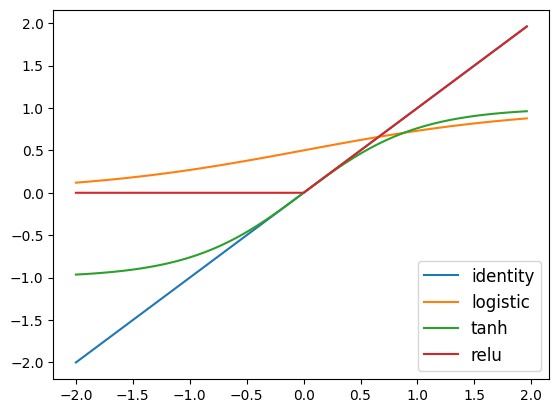

In [28]:
# jupyter lab/notebookの時のコマンド
%matplotlib inline
import matplotlib.pyplot as plt
x = 4*np.arange(100) / 100 - 2.0
plt.plot(x, x, label="identity") # identity
plt.plot(x, 1.0 / (1.0 + np.exp(-x)), label="logistic") # logistic
plt.plot(x, np.tanh(x), label="tanh") # tanh
plt.plot(x, np.maximum(x, 0), label="relu") # relu
plt.legend(fontsize=12, loc='lower right')
plt.show()

結果が悪かった`"identity"`と`"relu"`は非有界（つまり，関数の値がどこまでも大きくなるか小さくなる）ですが，比較的良い結果だった`"logistic"`と`"tanh"`は有界で，値域は前者が $(0, 1)$ ，後者が $(-1, 1)$ です．
そのため，以下のようなことが起こっているのではないかと考えられます：**活性化関数に通す前の中間層の値が非常に大きくなってしまっているのではないか？**

活性化関数に通す前の値は，「入力ベクトルと重み行列の積」によって計算されます．
したがって，特徴ベクトルの値が大きい場合，中間層の値が非常に大きくなってしまう可能性があります．
特徴ベクトルの値をちょっと思い出してみます．
one-hotエンコーディングによって作られた部分は0か1でした．
しかし楽曲の長さはミリ秒単位であるため，大きな値が入っていることもありそうです．
ちょっと見てみましょう．

In [29]:
print(np.max(X_train))

5237295.0


最大で7ケタの非常に大きな値が入っており，先程述べていたことが起こっている可能性が高そうに思えてきます．
また，そもそも，特徴の値の最大値と最小値の範囲が，各特徴毎に大きく異なるというのは問題となることがあります．
線形モデルの例を考えてみます．
one-hotエンコーディングされた特徴`"track_genre"`に関する重みを $w_j$ ，楽曲の長さ`"duration_ms"`に関する重みを $w_i$ とし， $w_j=w_i=0.01$ であるとします．
このとき， $x_j$ は最大でも1なので， $x_j=0$ の場合と比較しても予測の値が0.01増えるだけです．すなわち，one-hotエンコーディングされた特徴`"track_genre"`に関する重みが $w_j=0.01$ であることに大きな問題はなさそうです．
一方で，`"duration_ms"`に関する重みについて **$w_i=0.01$とすると問題が起こります．**例えば， $x_i$ の値が1,000,000程度のとき， $x_i=0$ の場合と比較して**予測の値がおよそ10,000も増えてしまいます**．
つまり，各特徴に対応するパラメータ（上の例では，$w_j$や$w_i$）のスケールはその特徴のスケールに応じて適切なものになっていなければなりません．

[sklearnのニューラルネットワークに関する解説(1.17.7. Tips on Practical Use)](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#tips-on-practical-use)を見てみましょう．
次のように書いてあります：

- "Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0, 1] or [-1, +1], or standardize it to have mean 0 and variance 1. Note that you must apply the same scaling to the test set for meaningful results. You can use StandardScaler for standardization."

ようするに，**MLPは特徴のスケールに影響を受けやすいので，そこらへんはどうにかしなさい（例えば，各特徴の値が$[0, 1]$や$[-1, 1]$の範囲に入るようにであったり，平均が0で分散が1になるようにしなさい）**と言っています．
このように，学習アルゴリズムに入れる前に，特徴量に対して何らかの変換を施すことを**前処理（preprocessing）**と言います（one-hotエンコーディングも前処理の一部であると言えるでしょう）．

## `sklearn.preprocessing`：sklearnの機能を使って特徴量のスケールを揃える

さて，それでは上で言われているように，特徴ベクトルのスケールを揃えてみましょう．
今回は各特徴量を $[0, 1]$ の範囲に（最小値が0で最大値が1になるように）スケーリングします．
numpyの演算を使うことでも比較的簡単にできますが，ここではsklearnの機能を使うことにします．

sklearnには`sklearn.preprocessing`というモジュールがあり，このモジュールの中に様々な前処理のための関数・クラスが用意されています．
今回は，**最大値と最小値を揃えるスケーリング**を行いたいわけですが，これは`sklearn.preprocessing`の中の[`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)によって行うことができます．


In [30]:
from sklearn.preprocessing import MinMaxScaler

# 以下を埋める
scaler = MinMaxScaler() # 引数の設定がないとき，MinMaxScalerは[0,1]にスケーリング
scaler.fit(X_train) # 訓練データにおける各特徴量の最大値・最小値を計算
X_train_scaled = scaler.transform(X_train) # 訓練データをスケーリングした行列を返す

# モデルを作成し，交差検証で評価
mlp = MLPRegressor(random_state=42) # random_state(乱数のseed値)を指定して初期パラメータを固定(比較検証用)
scores = cross_validate(mlp, X_train_scaled, y_train, cv=5,
                        scoring="neg_mean_squared_error",
                        return_train_score=True)
print(f"交差検証の5回のスコア：{-scores['test_score']}")
print(f"交差検証の平均スコア：{-np.mean(scores['test_score'])}")

print(f"交差検証の5回の訓練スコア：{-scores['train_score']}")
print(f"交差検証の平均訓練スコア：{-np.mean(scores['train_score'])}")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

交差検証の5回のスコア：[350.01263268 353.09139409 343.96391824 351.87037285 356.49486004]
交差検証の平均スコア：351.08663558047675
交差検証の5回の訓練スコア：[333.64234031 332.56536543 334.87623973 332.29357126 332.27680986]
交差検証の平均訓練スコア：333.13086531739435


スコアが改善しました！
しかもまだ細かいハイパーパラメータチューニングはしていませんから，更に性能の向上を見込めます．交差検証をして良いパラメータを定めてみましょう．

**※以下のコードは実行に数十分から数時間程度を要する見込みです．**短時間で実行する場合は適宜`MLPRegressor`の`max_iter`や`hidden_layer_sizes`の値を調整してみてください．


`X_train_scaled`を訓練データの入力として，`MLPRegressor`のハイパーパラメータを`GridSearchCV`によってチューニングします．
ここでは，2つのパラメータを以下の範囲でチューニングします：
- `hidden_layer_sizes`：(1)中間層が一つでユニット数が100 (2)中間層が2つでユニット数がそれぞれ80
- `activation`：(1) "logistic" (2) "tanh" (3) "relu"

In [31]:
mlp = MLPRegressor(max_iter=100, random_state=42)
params_grid = {
    "hidden_layer_sizes": [(100, ), (80, 80)],
    "activation": ["logistic", "tanh", "relu"]
}

cv = GridSearchCV(mlp, param_grid=params_grid, cv=5, scoring="neg_mean_squared_error")
cv.fit(X_train_scaled, y_train)
print(cv.best_params_) # 最も良かったハイパーパラメータを見てみる
print(-cv.best_score_) # 最も良かったハイパーパラメータの時のスコアを見てみる．わかりやすさのため符号は反転する．

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

{'activation': 'tanh', 'hidden_layer_sizes': (80, 80)}
345.6713450537636


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


この結果で得られたベストなモデルを使って予測結果を提出すると良いかもしれません．
その際，**テストデータの変換を行うのを忘れる・変換の仕方を誤る**と，ひどいスコアとなってしまうためご注意ください．
なお，上のチューニングはかなり粗く・雑に行っているので，より丁寧に行うことでより良いスコアが出る可能性は高いです．

## まとめ
- 多層パーセプトロン（MLP)：ニューラルネットワークの一種．（非線形な活性化関数を使った場合）非線形なモデルで，特徴ベクトルのスケールに影響を強く受ける．
- 前処理のための関数やクラスは`sklearn.preprocessing`にある．最大値と最小値のスケーリングは`MinMaxScaler`で行うことができる．

今回用いた`MinMaxScaler`以外にも前処理のクラス・関数は多数あるので，それらについても調べてみる・使ってみると良いかもしれません．
また，具体的に名前を列挙することはしませんが，非線形なモデルは`MLPRegressor`以外にも多数あります．
その中には，特徴ベクトルのスケールの影響を受けにくく，使いやすいモデルもあります．
また，興味深いことに，カテゴリカル変数をそのまま扱える手法もあります（残念ながらsklearnの実装ではそうなっておらず，その手法に特化したライブラリを使う必要がありますが）．
「どのような特徴を作るか」「どのような変換を施すか」「どのようなモデルを使うか」「どのようなハイパーパラメータにするか」を考えると，できることは山ほどあるので，是非色々試してみてください．

さらに，ここ10年弱の深層学習ブームにより，ニューラルネットワークのライブラリが多数開発されています．
それらを用いることでより自由に・柔軟にニューラルネットワークを構築することができます．
それらについても興味があれば調べてみると良いかもしれません．

今回は，予測モデルを構築する前の処理として，スケーリングを取り上げました．
それ以外にも，例えば
- 特徴選択（feature selection）：元の特徴量からいくつかの特徴量を選ぶ (特徴選択で作られた低次元ベクトルは，元の特徴ベクトルの部分ベクトル)
- 特徴抽出（feature extraction)：元の特徴量を用いて新しく（低次元の）特徴量を作り出す(元の特徴ベクトルの部分ベクトルとは限らない）

等の処理を行うと，性能が向上することもあります．
これらはsklearnでは[sklearn.feature_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)や[sklearn.decomposition](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition)に実装されています．
余裕がある方は試してみると良いかもしれません．

## 付録：EDA（Exploratory Data Analysis, 探索的データ分析）

ここまで，いくつかの学習モデルと様々な処理（one-hotエンコーディング，欠損値処理，交差検証，ハイパーパラメータ探索など）について見てきました．紹介した以外にも数多くのモデル([参考：scikit-learnの教師あり学習モデルまとめ](https://scikit-learn.org/stable/supervised_learning.html))や処理が存在し，その中で「うまくいく」方法を見つけることがコンペでよいスコアを出すためには重要です．しかし，片っ端からありとあらゆる手法を試すのは時間的な制約（コンペの開催期間）から考えても難しいでしょう．したがって，コンペにおいては「うまくいきそうな」手法を優先的に試すことになると思います．このときの手法選択の手がかりをつかむための手法として **EDA（Exploratory Data Analysis, 探索的データ分析）** が挙げられます．

EDAでは，与えられたデータの特徴をつかみます．具体的には，

- どのようなデータ（種類，数）が与えられているか
- 各データの分布，例えば最大値や最小値，平均値や分散はどうなっているか
- 欠損値はどれほど存在するか
- 説明変数どうし，あるいは説明変数と目的変数の間に相関はあるか

といった情報を

- 棒グラフ
- 箱ひげ図
- 散布図
- 折れ線グラフ
- ヒートマップ
- ヒストグラム

などの可視化手法を用いて可視化し，データに関する情報を得ることを狙いとします．これらの情報は，どのようなモデルや手法なら「うまくいきそうか」，またどのような処理を行うべきかの参考にすることができます．

EDAは，適宜必要なコードを自分で書き行うこともできますが，自分で0からコードを書くのは大変かもしれません．
最も楽な方法の一つとして，`ydata-profiling`（[ドキュメント](https://docs.profiling.ydata.ai/latest/)）のような既存の可視化ツールを使用することが挙げられます．
以下で、`ydata-profiling`の簡単な使用方法について説明します．

例えば訓練データの情報を見たいとき，以下のように実行できます．


In [2]:
# Google Colabを使っている場合は以下のコメントアウトを外して実行し，ydata-profilingをインストール
# !pip install --upgrade ydata-profiling

# ローカル環境の場合、適宜インストールを行う

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 11.9 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=43eabebe1e25d538bec17480aaa51930539fbfb4c25033a347b9f9094675d90a
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [5]:
from ydata_profiling import ProfileReport
profile = ProfileReport(pd.read_csv("drive/My Drive/data/train.csv"))
profile.to_file("profile.html") # Colab環境では直接描画できないため，htmlとして出力

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

上のセルを実行すると，様々な情報が確認できると思います．こうした情報をもとにモデルや手法を探すことで，より良いスコアを狙うことができます．一般にコンペにおいては正解というものはありません．データと自分の直感とをすり合わせ，思い思いのモデルを作成してみてください．

参考文献：「Kaggleで勝つデータ分析の技術」（2019，門脇大輔ほか，技術評論社）